# Import Libraries and Tools

In [2]:
import random
import os
import time
# Turn off tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# For Data Processing & ML Models
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import cv2

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Enable offline usage of plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from IPython.display import clear_output
clear_output()

# Load Dataset

In [3]:
base_dir = '/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset'
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
filepaths = []
labels = []
for cls in classes:
    class_dir = os.path.join(base_dir, cls)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            filepaths.append(os.path.join(class_dir, fname))
            labels.append(cls)
# Build DataFrame with filename, label, filepath
df = pd.DataFrame({
    'filename': [os.path.basename(fp) for fp in filepaths],
    'label': labels,
    'filepath': filepaths
})
df.head()

,filename,label,filepath
0,mildDem412.jpg,MildDemented,/kaggle/input/augmented-alzheimer-mri-dataset/...
1,mildDem257.jpg,MildDemented,/kaggle/input/augmented-alzheimer-mri-dataset/...
2,mildDem276.jpg,MildDemented,/kaggle/input/augmented-alzheimer-mri-dataset/...
3,mildDem682.jpg,MildDemented,/kaggle/input/augmented-alzheimer-mri-dataset/...
4,mildDem376.jpg,MildDemented,/kaggle/input/augmented-alzheimer-mri-dataset/...


splitting

In [4]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Data Visualization

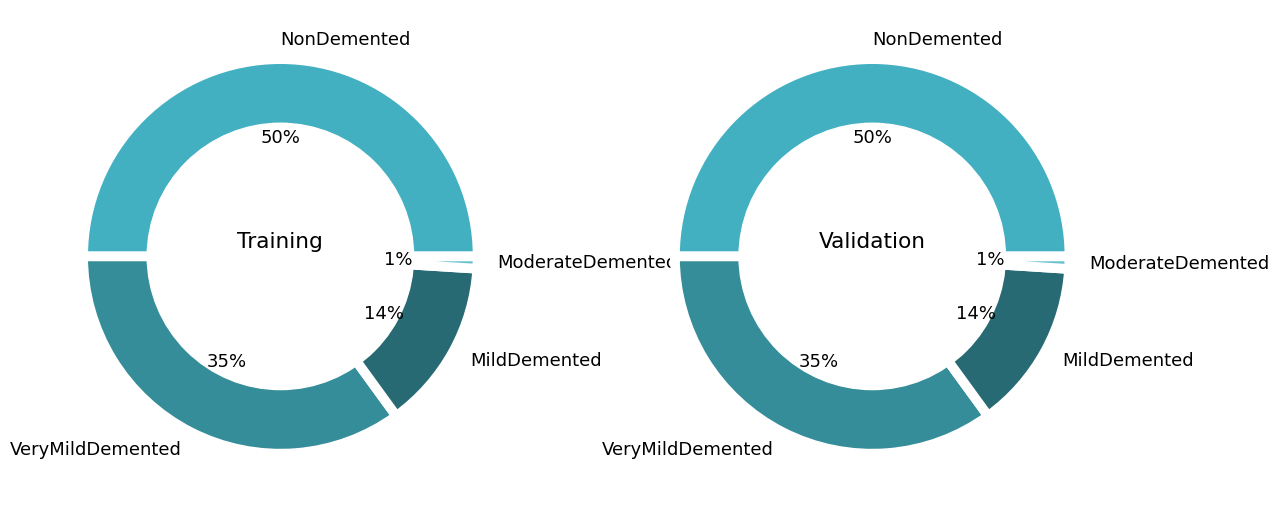

In [5]:
plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(14, 7))

fig.add_subplot(1, 2, 1)
plt.pie(list(train_df.label.value_counts()),
        labels=list(train_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Training', x=0.5, y=0.5) 


fig.add_subplot(1, 2, 2)
plt.pie(list(val_df.label.value_counts()),
        labels=list(val_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Validation', x=0.5, y=0.5) 

plt.show()

In [6]:
print(f"Training samples: {len(train_df)}, Test samples: {len(val_df)}")

Training samples: 5120, Test samples: 1280


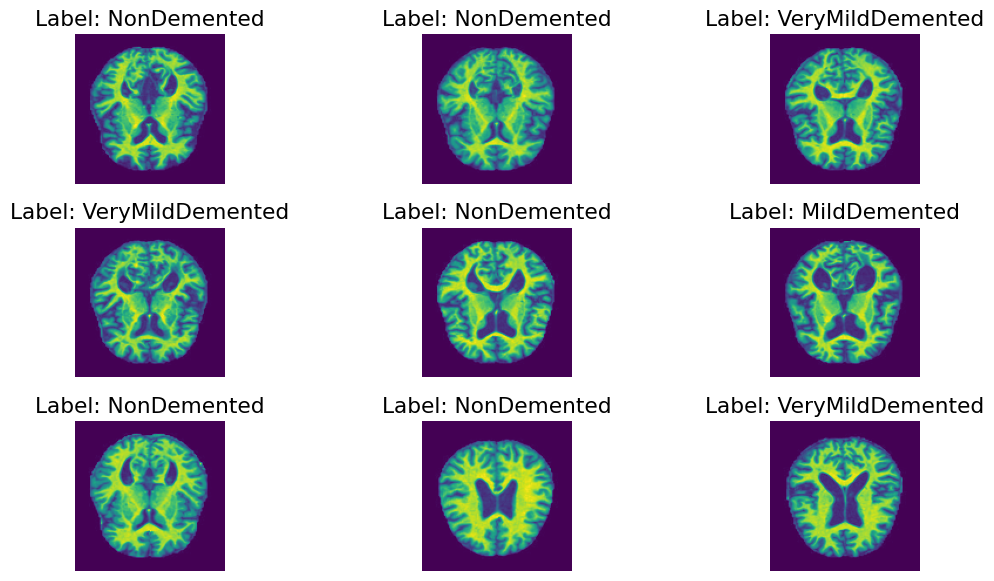

In [7]:
# Select random indices for 9 images
sample_indices = random.sample(range(len(train_df)), 9)

plt.figure(figsize=(12, 6))

for i, sample_idx in enumerate(sample_indices):
    im = Image.open(train_df.filepath[sample_idx]).resize((128, 128))
    
    plt.subplot(3, 3, i+1)   
    plt.imshow(im)  
    plt.axis("off")
    plt.title(f"Label: {train_df.label[sample_idx]}")  

plt.tight_layout()
plt.show()


# Image Preprocessing

In [8]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(filepaths):
    images = []
    for path in filepaths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(base_dir)  
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(filepaths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(filepaths), batch_size):
            batch_paths = filepaths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# Model : VGG16 for Transfer Learning

In [9]:
# Set image size
IMAGE_SIZE = 224

# Define input layer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Load VGG16 without top
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = True

# Freeze all but last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False


I0000 00:00:1762693688.717226      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: input_layer, Trainable: False
Layer 1: block1_conv1, Trainable: False
Layer 2: block1_conv2, Trainable: False
Layer 3: block1_pool, Trainable: False
Layer 4: block2_conv1, Trainable: False
Layer 5: block2_conv2, Trainable: False
Layer 6: block2_pool, Trainable: False
Layer 7: block3_conv1, Trainable: False
Layer 8: block3_conv2, Trainable: False
Layer 9: block3_conv3, Trainable: False
Layer 10: block3_pool, Trainable: False
Layer 11: block4_conv1, Trainable: False
Layer 12: block4_conv2, Trainable: False
Layer 13: block4_conv3, Trainable: False
Layer 14: block4_pool, Trainable: False
Layer 15: block5_conv1, Trainable: True
Layer 16: block5_conv2, Trainable: True
Layer 17: block5_conv3, Trainable: True
Layer 18: block5_pool, Trainable: True


In [11]:
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

# Final model
model = Model(inputs=inputs, outputs=outputs)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             

 Total params: 14,848,068 (56.64 MB)

 Trainable params: 7,212,292 (27.51 MB)

 Non-trainable params: 7,635,776 (29.13 MB)

In [12]:
# Load and shuffle the train data
train_paths = train_df['filepath']
train_labels = train_df['label']


# Load the test data
val_paths = val_df['filepath']
val_labels = val_df['label']

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

batch_size = 32
train_steps = len(train_df) // batch_size
val_steps = len(val_df) // batch_size
epochs = 25

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model_nih.h5',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_data=datagen(val_paths, val_labels, batch_size=batch_size, epochs=epochs),
    validation_steps=val_steps,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/25


I0000 00:00:1762693693.351760     110 service.cc:148] XLA service 0x7fc5480029a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762693693.352701     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762693693.832132     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/160 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.2500 - loss: 2.1781 

I0000 00:00:1762693703.617291     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.2668 - loss: 1.9279
Epoch 1: val_accuracy improved from -inf to 0.47656, saving model to best_model_nih.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 85s 454ms/step - accuracy: 0.2669 - loss: 1.9272 - val_accuracy: 0.4766 - val_loss: 1.2509 - learning_rate: 1.0000e-04
Epoch 2/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.3743 - loss: 1.5512
Epoch 2: val_accuracy improved from 0.47656 to 0.58281, saving model to best_model_nih.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.3745 - loss: 1.5507 - val_accuracy: 0.5828 - val_loss: 1.1388 - learning_rate: 1.0000e-04
Epoch 3/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.4804 - loss: 1.3045
Epoch 3: val_accuracy did not improve from 0.58281
160/160 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.4806 - loss: 1.3042 - val_accuracy: 0.5188 - val_loss: 1.4223 - learning_rate: 1.0000e-04
Epoch 4/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5878 - loss: 1.0774
Epoch 4: val_accuracy improved from 0.58281 to 0.71328, saving model to best_model_nih.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 34s 211ms/step - accuracy: 0.5880 - loss: 1.0769 - val_accuracy: 0.7133 - val_loss: 0.7895 - learning_rate: 1.0000e-04
Epoch 5/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.6949 - loss: 0.8235
Epoch 5: val_accuracy improved from 0.71328 to 0.79688, saving model to best_model_nih.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - accuracy: 0.6951 - loss: 0.8231 - val_accuracy: 0.7969 - val_loss: 0.5850 - learning_rate: 1.0000e-04
Epoch 6/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8159 - loss: 0.5414
Epoch 6: val_accuracy did not improve from 0.79688
160/160 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - accuracy: 0.8160 - loss: 0.5410 - val_accuracy: 0.6281 - val_loss: 1.0368 - learning_rate: 1.0000e-04
Epoch 7/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8857 - loss: 0.3307
Epoch 7: val_accuracy improved from 0.79688 to 0.86406, saving model to best_model_nih.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 30s 188ms/step - accuracy: 0.8858 - loss: 0.3306 - val_accuracy: 0.8641 - val_loss: 0.3963 - learning_rate: 1.0000e-04
Epoch 8/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9317 - loss: 0.2031
Epoch 8: val_accuracy did not improve from 0.86406
160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 177ms/step - accuracy: 0.9317 - loss: 0.2030 - val_accuracy: 0.8500 - val_loss: 0.4783 - learning_rate: 1.0000e-04
Epoch 9/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9536 - loss: 0.1476
Epoch 9: val_accuracy improved from 0.86406 to 0.90859, saving model to best_model_nih.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 176ms/step - accuracy: 0.9536 - loss: 0.1475 - val_accuracy: 0.9086 - val_loss: 0.2861 - learning_rate: 1.0000e-04
Epoch 10/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9678 - loss: 0.0980
Epoch 10: val_accuracy improved from 0.90859 to 0.91719, saving model to best_model_nih.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.9678 - loss: 0.0979 - val_accuracy: 0.9172 - val_loss: 0.2401 - learning_rate: 1.0000e-04
Epoch 11/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9830 - loss: 0.0596
Epoch 11: val_accuracy improved from 0.91719 to 0.95312, saving model to best_model_nih.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9830 - loss: 0.0596 - val_accuracy: 0.9531 - val_loss: 0.1392 - learning_rate: 1.0000e-04
Epoch 12/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9845 - loss: 0.0527
Epoch 12: val_accuracy did not improve from 0.95312
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.9845 - loss: 0.0526 - val_accuracy: 0.9273 - val_loss: 0.2237 - learning_rate: 1.0000e-04
Epoch 13/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9866 - loss: 0.0447
Epoch 13: val_accuracy did not improve from 0.95312
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 170ms/step - accuracy: 0.9866 - loss: 0.0447 - val_accuracy: 0.9219 - val_loss: 0.2643 - learning_rate: 1.0000e-04
Epoch 14/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9918 - loss: 0.0334
Epoch 14: val_accuracy did not improve from 0.95312
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.9918 - loss: 0.0334 - val_accuracy: 0.9320 - val_loss: 0.2152 - learning_ra

# Loss and Accuracy plots

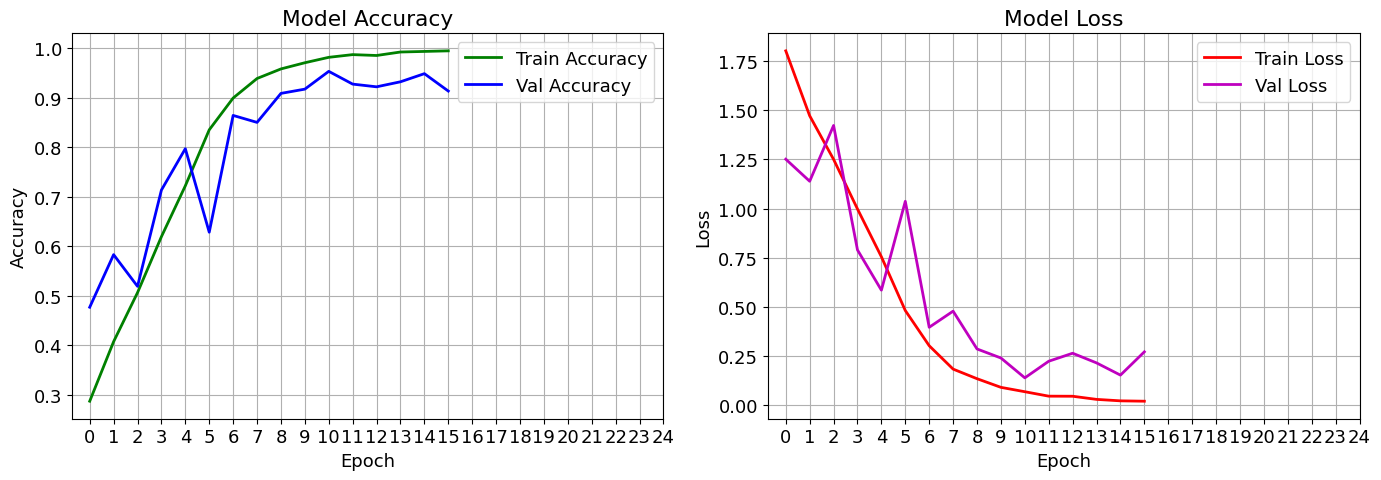

In [14]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'g-', linewidth=2, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'b-', linewidth=2, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(epochs))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r-', linewidth=2, label='Train Loss')
plt.plot(history.history['val_loss'], 'm-', linewidth=2, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(epochs))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Model Classification Report

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# 1. Prediction on test data
test_images = open_images(val_paths)  # Load and augment test images
test_labels_encoded = encode_label(val_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.97      0.98      0.97       640
           2       0.96      0.95      0.95       448
           3       0.94      0.95      0.94       179

    accuracy                           0.96      1280
   macro avg       0.94      0.89      0.91      1280
weighted avg       0.96      0.96      0.96      1280



# Confusion Plot

Confusion Matrix:
[[  9   0   4   0]
 [  0 625   9   6]
 [  1  17 425   5]
 [  0   2   7 170]]


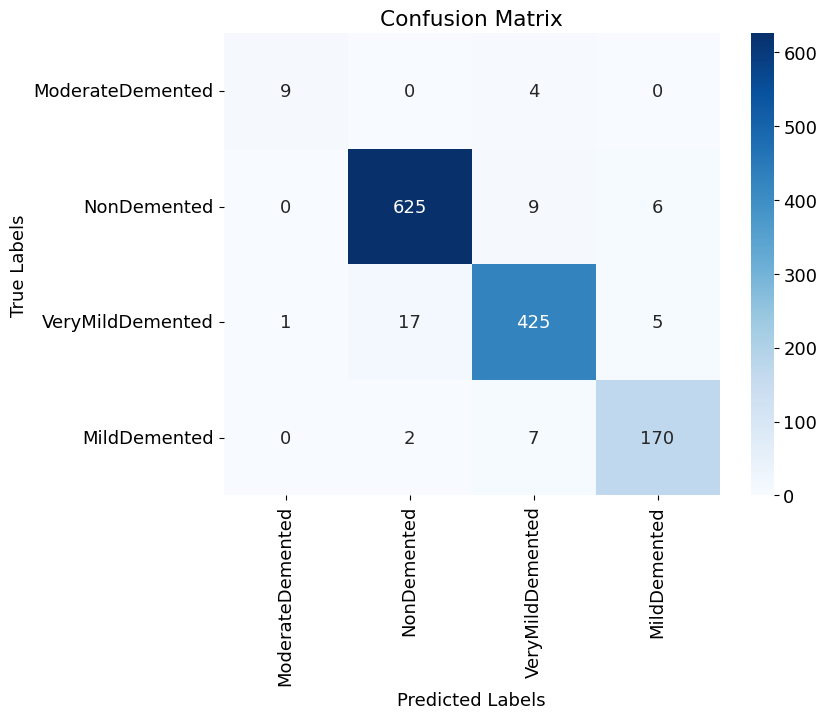

In [16]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(base_dir), yticklabels=os.listdir(base_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Brain MRI Alzheimer Stage Detection

In [17]:
from keras.preprocessing.image import load_img, img_to_array

# Class labels
class_labels = ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

def detect_and_display(img_path, model, image_size=224):
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'NonDemented':
            result = "NonDemented"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


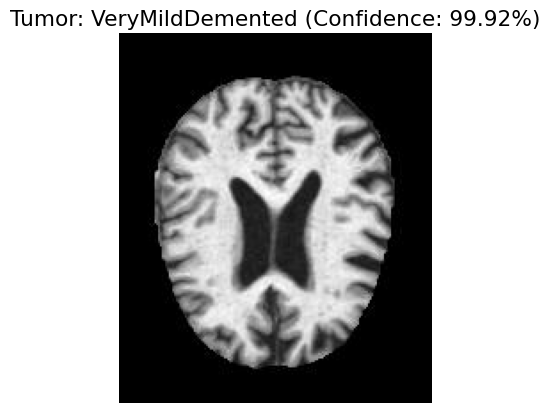

In [18]:
path = '/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset/VeryMildDemented/26 (48).jpg'
detect_and_display(path, model)

# Saving the best model

In [19]:
from IPython.display import FileLink

# If saved in same directory
FileLink('best_model_nih.h5')

/kaggle/working/best_model_nih.h5

# Deployment

I used **[Gradio](https://www.gradio.app/)** to build the web interface and **[Hugging Face Spaces](https://huggingface.co/spaces)** to deploy the website.
You can get the source code of my gradio app here: **[Anurag/Alzheimer's_Disease_Stage_Detection](https://huggingface.co/spaces/anurag4real/Alzheimer_Disease_Stage_Detection)**

In [ ]:
from IPython.display import IFrame

# Replace this with your actual Space link
url = "https://huggingface.co/spaces/anurag4real/Alzheimer_stage_Classfication"
IFrame(src=url, width=900, height=600)
